In [2]:
import numpy as np
import time
import qutip as qt
from qutip.solver import Options
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.linalg import expm
import itertools
from tqdm import tqdm
import pandas as pd
qt.settings.num_cpus

12

# Explicações: 

Duas reflexões geram uma rotação no plano span{bom,ruim}. Se $a$ é a probabilidade de sucesso antes do QAA ($a=\sin^⁡2\theta$), então após $r$ aplicações:

$Pr⁡ob(bom)=\sin^⁡2⁣((2r+1)\theta)$, ou seja, a massa de probabilidade “gira” dos estados ruins para os bons.

QAA:

$a_0 = \sin^2(\theta) \Rightarrow \theta = \arcsin(\sqrt{a_0})$

Após $r$ iterações do operador $G$, a probabilidade de sucesso será: 

$a_r = \sin^2[(2r+1)\theta]$, com máximo quando $(2r+1)\theta =\pi/2$. Assim, $r_\text{max} = \frac{\pi}{4\theta} - \frac{1}{2}$

In [3]:
# =========================================================
# Funções
# =========================================================
def qft(m):
    if m < 1:
        raise ValueError("Minimum value of N can be 1")
    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)  # Lista de y: [0, 2^m-1]
    L, C = np.meshgrid(y, y)  # L - cópia de y nas linhas, C - cópia de y nas colunas
    P = phase * (L * C)  # Matriz de fase para cada combinação de estados
    P = np.exp(P)        # Matriz de transformação de fase exponencial
    dim = [[2] * m, [2] * m]  # Dimensão da matriz
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)

def construir_operadores(num_qubits, dim_q, dim_f):
    # Operadores σ_-
    sigma_m = []
    for q in range(num_qubits):
        op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
        op_list.append(qt.qeye(dim_f))
        op_list[q] = qt.sigmam()
        sigma_m.append(qt.tensor(op_list))
    # Operador a (aniquilação no modo do campo)
    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
    op_list.append(qt.qeye(dim_f))
    op_list[-1] = qt.destroy(dim_f)
    a = qt.tensor(op_list)
    # QFT total (qubits) ⊗ I_campo
    qft_total = qt.tensor(qft(num_qubits), qt.qeye(dim_f))
    return sigma_m, a, qft_total

def preparar_estado_inicial(num_qubits, dim_f, N):
    state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]
    alpha = np.sqrt(N) 
    state_i_field = qt.coherent(dim_f, alpha)
    state_i = qt.tensor(state_i_qubits + [state_i_field])
    return state_i_qubits, state_i_field, state_i

def construir_base_qubits(num_qubits):
    basis_states = []
    for bits in itertools.product([0, 1], repeat=num_qubits):
        state = qt.tensor([qt.basis(2, bit) for bit in bits])
        basis_states.append(state)
    return basis_states

def c_eff(t, args):
    return 1.0 if t <= args["t_f_int"] else 0.0

def construir_estado_puro_do_campo(state_total, num_qubits):
    rho_f = state_total.ptrace(num_qubits)
    vals, vecs = rho_f.eigenstates()
    state_f_puro = sum(np.sqrt(val) * vec for val, vec in zip(vals, vecs))
    return state_f_puro.unit()

def last_state_qobj(result, template_state=None):
    x = result.states
    while isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            raise ValueError("result.states está vazio.")
        x = x[-1]
    if isinstance(x, qt.Qobj):
        return x
    arr = np.asarray(x, dtype=complex).reshape((-1, 1))
    if template_state is not None:
        dims = template_state.dims
    else:
        dims = [[arr.shape[0]], [1]]
    return qt.Qobj(arr, dims=dims)

def y_from_N(N, num_qubits, N_max):
    """  
    Cria o índice-y alvo
    N % N_max: fase efetiva periódica em N_max
    N % N_max) * (2**num_qubits) / N_max: valor real que a QPE retorna da fração theta para o valor y
    round: arredonda para garantir y inteiro
    int e % (2**num_qubits): garante que o round não aproxime para fora do intervalo
    """
    return int(np.round((N % N_max) * (2**num_qubits) / N_max)) % (2**num_qubits)

def projector_y(y, num_qubits):
    """ 
    Cria o projetor de cada y 
    format: transforma o inteiro y em representação binária com num_qubits
    bits: associa cada bit string a um inteiro, incluído numa lista
    ket: base computacional correspondente aos bits
    """
    
    bits = list(map(int, format(y, f'0{num_qubits}b')))
    ket  = qt.tensor([qt.basis(2, b) for b in bits])
    return ket*ket.dag()

def bit_reverse(y, m):
    """
    Converte a ordem dos bits, segundo a convenção comum em QFT quando não se usam swaps finais
    Em vez de add SWAPs na função, aplicamos bit_reverse ao alvo teórico y0 para alinhar as convenções
    f'{y:0{m}b}': escreve y em binário com m bits
    [::-1]: inverte a string
    int(..., 2): lê a string invertida como inteiro base 2
    """
    return int(f'{y:0{m}b}'[::-1], 2)

def circ_dist(a, b, M):
    """
    Calcular distância circular (em anel) entre fases
    circ_dist(a,b,M)=min(∣a−b∣,M−∣a−b∣).
    """
    d = abs(a-b)
    return min(d, M-d)

def succ(r): 
    """
    Função sucesso para cada r candidato
    """
    return np.sin((2*r + 1)*theta)**2


# =========================
# Parâmetros
# =========================
num_qubits = 7               # Número de qubits
N_max = 2 ** num_qubits      # Grade para QPE (discretização)
dim_q = 2                    # Dimensão dos qubits
dim_f = N_max                # Dimensão do campo
N = 50                      # Fock alvo: |N> (< dim_f)
kappa = 1.0                  # Decaimento do campo

# Escala de tempo para uma rodada da QPE (irrelevante sem dissipação)
T_vm = 5.0 / kappa
num_qpe = 1                             # sempre 1              
frac_int = 0.0002                       # 10^{-3}/kappa
t_ciclo = T_vm / num_qpe
t_f_int = frac_int * t_ciclo
t_list_round = np.array([0.0, t_f_int]) # Como não há dissiparação, só dois pontos

# Calibração: g_k * t_f_int = 2π * 2^k / N_max
g_list = [(2*np.pi * (2**g) / N_max) / t_f_int for g in range(num_qubits)]
g_list = g_list[::-1]



# =========================================================
# Operadores e estados
# =========================================================
sigma_m, a, qft_total = construir_operadores(num_qubits, dim_q, dim_f)
n_op = a.dag() * a
state_i_qubits, state_i_field, state_i = preparar_estado_inicial(num_qubits, dim_f, N)

basis_states = construir_base_qubits(num_qubits)
proj_list = [qt.tensor(s * s.dag(), qt.qeye(dim_f)) for s in basis_states]
proj_list_qft = [qft_total * P * qft_total.dag() for P in proj_list]

# Operador de colapso nulo
c_ops = [np.sqrt(kappa) * a]

H_eff = 0
for q in range(num_qubits):
    H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
H_free = 0 * H_eff
H_td = [[H_eff, c_eff]]

# =====
# QAA 
# =====
# Semilargura da janela de y
w  = 0  
# Máximo de iterações
r_cap = 30    

# Operadores identidade campo e qubits
I_f = qt.qeye(dim_f) 
I_q = qt.tensor([qt.qeye(2) for _ in range(num_qubits)])
I_total = qt.tensor(I_q, I_f)


# =========================
# Evolução via Monte Carlo 
# =========================
ntraj_global = 1
prob_global_ntraj_list = np.zeros((num_qpe, 2**num_qubits), dtype=float)
mean_photons = np.zeros(num_qpe, dtype=float)

opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
               store_states=False, store_final_state=True)

# Semente aleatória
qt.settings.mc_seed = np.random.randint(1e9)

# Evolução (vira SE, pois não há dissipação)
data = qt.mcsolve(H_td, state_i, t_list_round, c_ops, e_ops=None,
                    args={"t_f_int": t_f_int}, options=opts, ntraj=1, progress_bar=None)

# Estado final
state_f = last_state_qobj(data, template_state=state_i)

# Probabilidade SEM amplificação
probs_no_amp = np.real(qt.expect(proj_list_qft, state_f))
probs_no_amp = np.clip(probs_no_amp, 0.0, 1.0)
s0 = probs_no_amp.sum()
if s0 > 0 and abs(s0 - 1.0) > 1e-12:
    probs_no_amp /= s0


# Alvo da QPE
y0_eff_val = y_from_N(N, num_qubits, N_max)   
y_peak = int(np.argmax(probs_no_amp))    # só para verificação
        
# Limita o conjunto alvo do oráculo
good_set = list(range(max(0, y0_eff_val - w), min(N_max, y0_eff_val + w + 1)))
        
# Definição do oráculo
## Projetores dentro do intervalo adotado
P_good_comp = sum(projector_y(y, num_qubits) for y in good_set) 

## Phase oracle / oráculo de Grove / S_chi: reflexão em torno do subespaço good
### Fase -1 se y pertence ao conjunto good
S_good_comp = (I_q - 2*P_good_comp)

## Transforma na base da IQFT
S_chi_qft_qubits = qft(num_qubits) * S_good_comp * qft(num_qubits).dag()
S_chi_total = qt.tensor(S_chi_qft_qubits, I_f)
    

# Reflexão em torno do estado preparado 
P_psi_total = state_f * state_f.dag()
S_psi_total = (I_total - 2 * P_psi_total)

# QAA nos qubits 
state_after_y = state_f
        
# Número de iterações de Grover (probabilidade inicial de sucesso na medida em y)
a0 = float(np.clip(np.sum([probs_no_amp[y] for y in good_set]), 0.0, 1.0))
if a0 <= 0.0:
    r_y = 2
else:
    ## Número de iterações de Grover
    theta = np.arcsin(np.sqrt(a0))
    r_otimo = np.pi/(4.0*theta) - 0.5
            
    cand = [int(np.floor(r_otimo)), int(np.ceil(r_otimo))]         # maior (floor) ou menor (ceil) inteiro mais próximo
    cand = [int(np.clip(r, 0, r_cap)) for r in cand]               # clip para manter no intervalo permitido
            
    r_y = max(cand, key=succ)                                      # Escolhe o r que gera a maior probabilidade de sucesso inicial

        
## Aplica amplificação (passo de Grover)
G_y = S_psi_total * S_chi_total
for _ in range(r_y):
    state_after_y = G_y * state_after_y
                
state_f_amp = state_after_y

# Probabilidade COM amplificação (deslocamento das probabilidades em torno dos valores de good_set)
probs = np.real(qt.expect(proj_list_qft, state_f_amp))
probs = np.clip(probs, 0.0, 1.0)
s = probs.sum()
if s > 0 and abs(s - 1.0) > 1e-12:
    probs /= s
prob_global_ntraj_list = probs

# Número de fótons (não precisa usar o amplificado pq ele só atua nos qubits)
mean_photons = float(np.real(qt.expect(n_op, state_f)))

# Estado do campo condicionado ao sucesso (medição nos qubits)
P_good_qft_total = sum(proj_list_qft[y] for y in good_set)
p_succ = float(np.real((state_f_amp.dag() * P_good_qft_total * state_f_amp).tr()))

if p_succ > 1e-14:
    state_cond = (P_good_qft_total * state_f_amp).unit()
    rho_field_cond = state_cond.ptrace(num_qubits)
    ket_N = qt.fock(dim_f, N)
    fid_N = float(np.real((ket_N.dag() * rho_field_cond * ket_N)[0,0]))    
else:
    rho_field_cond = None
    fid_N = 0.0

    
# Prints
print(r'Conjunto good: ', good_set)
print(f"Probabilidade inicial de sucesso a_0={a0:.4f}, r_y={r_y}")
print(f"P max QPE={y_peak}, alvo y0_eff={y0_eff_val}")
print(f"P_sucesso(y) antes={np.sum([probs_no_amp[y] for y in good_set]):.4f} | "
    f"depois={np.sum([probs[y] for y in good_set]):.4f} | "
    f"fidelidade(cond) |N>={fid_N:.4f}")

# Calculo do número de shots da QPE
eta = np.log(1-0.95)/np.log(1-a0)
print('Número de shots mínimo da QPE'+r'$\eta_\text{shots}=$',eta)

# Salvamento instantâneo: útil para mais rodadas
probs_no_amp_last = probs_no_amp.copy()
probs_amp_last    = probs.copy()
p_succ_last       = p_succ
rho_field_cond_last = rho_field_cond if p_succ > 1e-14 else None


# Médias
prob_time_array = prob_global_ntraj_list 
mean_photons = mean_photons 


# =========================
# Plot distribuição
# =========================

# P_y x y: antes e depois da amplificação

fig, ax = plt.subplots(figsize=(8, 3.2))

y_vals = np.arange(2**num_qubits)
wbar = 0.45
ax.bar(y_vals - wbar/2, probs_no_amp_last, color='blue', width=wbar, alpha=0.7, label='Antes (sem QAA)')
ax.bar(y_vals + wbar/2, probs_amp_last, color='red', width=wbar, alpha=0.7, label='Depois (com QAA)')

# destacar os y do conjunto "bom"
for y in good_set:
    ax.axvspan(y-0.5, y+0.5, alpha=0.30, color='tab:green', label='Good set values')

ax.set_xlabel(r'$y$')
ax.set_ylabel(r'Probabilidade $P_y$')
ax.set_xticks(y_vals)
ax.set_xlim(-0.5, y_vals[-1] + 0.5)
ax.set_ylim(0.0, 1.0)
ax.grid(True, linestyle='--', alpha=1.0)
ax.legend()
ax.set_title(f"Alvo $y_0=${y0_eff_val}. Probabilidade de sucesso antes$=${probs_no_amp_last[good_set].sum():.3f}, depois$=${probs_amp_last[good_set].sum():.3f}")

# P_n x n: estado inicial vs final condicionado 
fig, ax2 = plt.subplots(figsize=(8, 3.2))

# P_n inicial 
Pn_i = np.abs(state_i_field.full().ravel())**2
ax2.bar(np.arange(dim_f), Pn_i, color='purple', width=wbar, alpha=0.7, label=r'Estado inicial: $|\alpha\rangle$')

# P_n final condicionado
Pn_f = np.real(np.diag(rho_field_cond_last.full()))
ax2.bar(np.arange(dim_f) + 0.45/2, Pn_f, color = 'green', width=0.45, alpha=0.7, label='Estado final condicionado: QAA + medição boa')

ax2.axvline(N, linestyle='--', alpha=0.7, label=r'Estado de Fock $|N \rangle$ alvo')
ax2.set_xlabel('n')
ax2.set_ylabel('Probabilidade $P_n$')
#ax2.set_xticks(np.arange(dim_f))
ax2.set_xlim(0.0, dim_f)
ax2.set_ylim(0.0, 1.0)
ax2.grid(True, linestyle='--', alpha=1.0)
ax2.legend()

plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 2.91 GiB for an array with shape (195479974,) and data type complex128

In [2]:
# Calculo do número de shots da QPE
eta = np.log(1-0.95)/np.log(1-0.028195831100668842)
print('Número de shots mínimo da QPE'+r'$\eta_\text{shots}=$',eta)

Número de shots mínimo da QPE$\eta_\text{shots}=$ 104.74234169377169


Código para notebook

In [4]:
import numpy as np
import itertools
import pandas as pd
import qutip as qt
from qutip.solver import Options
print(qt.__version__)

# =========================================================
# Funções (mantidas o máximo possível)
# =========================================================
def qft(m):
    if m < 1:
        raise ValueError("Minimum value of N can be 1")
    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)
    L, C = np.meshgrid(y, y)
    P = np.exp(phase * (L * C))
    dim = [[2] * m, [2] * m]
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)

def construir_operadores(num_qubits, dim_q, dim_f):
    sigma_m = []
    for q in range(num_qubits):
        op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
        op_list.append(qt.qeye(dim_f))
        op_list[q] = qt.sigmam()
        sigma_m.append(qt.tensor(op_list))

    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
    op_list.append(qt.qeye(dim_f))
    op_list[-1] = qt.destroy(dim_f)
    a = qt.tensor(op_list)

    # QFT só nos qubits (vamos aplicar via reshape)
    qft_qubits = qft(num_qubits)
    return sigma_m, a, qft_qubits

def preparar_estado_inicial(num_qubits, dim_f, N):
    state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]
    alpha = np.sqrt(N)
    state_i_field = qt.coherent(dim_f, alpha)
    state_i = qt.tensor(state_i_qubits + [state_i_field])
    return state_i_qubits, state_i_field, state_i

def c_eff(t, args):
    return 1.0 if t <= args["t_f_int"] else 0.0

def last_state_qobj(result, template_state=None):
    x = result.states
    while isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            raise ValueError("result.states está vazio.")
        x = x[-1]
    if isinstance(x, qt.Qobj):
        return x
    arr = np.asarray(x, dtype=complex).reshape((-1, 1))
    if template_state is not None:
        dims = template_state.dims
    else:
        dims = [[arr.shape[0]], [1]]
    return qt.Qobj(arr, dims=dims)

def y_from_N(N, num_qubits, N_max):
    return int(np.round((N % N_max) * (2**num_qubits) / N_max)) % (2**num_qubits)

def circ_dist(a, b, M):
    d = abs(a-b)
    return min(d, M-d)

# =========================
# Rotinas "memory-safe" (novas)
# =========================
def _reshape_state_to_matrix(state, num_qubits, dim_f):
    """State ket -> matriz (2^m, dim_f) com qubits como índice de linha e campo como coluna."""
    m = 2**num_qubits
    vec = state.full().reshape((m, dim_f), order='C')
    return vec

def _matrix_to_state(mat, template_state):
    """Matriz (2^m, dim_f) -> Qobj ket com dims do template."""
    vec = mat.reshape((-1, 1), order='C')
    return qt.Qobj(vec, dims=template_state.dims)

def compute_Py_from_state(state, qft_qubits, num_qubits, dim_f):
    """
    Calcula P_y como se você medisse os qubits após aplicar IQFT (qft_qubits.dag()).
    Isso é equivalente ao seu uso de proj_list_qft, mas sem construir projetores.
    """
    Udag = qft_qubits.dag().full()  # (2^m x 2^m)
    mat = _reshape_state_to_matrix(state, num_qubits, dim_f)
    mat_y = Udag @ mat
    probs = np.sum(np.abs(mat_y)**2, axis=1).real
    s = probs.sum()
    if s > 0 and abs(s - 1.0) > 1e-12:
        probs = probs / s
    return probs

def apply_S_psi_total_ket(state, psi_ref):
    """
    Reflexão rank-1: (I - 2|psi><psi|) |state>
    Evita construir S_psi_total como operador.
    """
    psi_ref = psi_ref.unit()
    overlap = (psi_ref.dag() * state)[0, 0]
    return state - 2.0 * overlap * psi_ref

def apply_S_chi_total_ket(state, good_set, qft_qubits, num_qubits, dim_f):
    """
    Aplica S_chi_total = (QFT ⊗ I) (I - 2 P_good_comp ⊗ I) (QFT^† ⊗ I)
    sem construir operadores grandes:
      1) IQFT nos qubits
      2) flip de sinal nas linhas y ∈ good_set
      3) QFT nos qubits
    """
    U = qft_qubits.full()
    Udag = qft_qubits.dag().full()

    mat = _reshape_state_to_matrix(state, num_qubits, dim_f)
    mat_comp = Udag @ mat  # vai para base computacional de y
    mat_comp[list(good_set), :] *= -1.0  # aplica S_good_comp (fase -1 nos "good")
    mat_back = U @ mat_comp
    return _matrix_to_state(mat_back, state)

def conditioned_field_from_state(state, good_set, qft_qubits, num_qubits, dim_f):
    """
    Condiciona no sucesso (qubits em good_set após IQFT) e devolve rho_field_cond e p_succ.
    Faz tudo por reshape e produto matricial.
    """
    Udag = qft_qubits.dag().full()
    mat = _reshape_state_to_matrix(state, num_qubits, dim_f)
    mat_y = Udag @ mat  # amplitudes em y-basis (computacional)

    mask = np.zeros(2**num_qubits, dtype=bool)
    mask[list(good_set)] = True

    mat_good = mat_y[mask, :]
    p_succ = float(np.sum(np.abs(mat_good)**2).real)

    if p_succ <= 1e-14:
        return p_succ, None

    mat_good = mat_good / np.sqrt(p_succ)
    rho_field = mat_good.conj().T @ mat_good  # (dim_f x dim_f)

    rho_field_qobj = qt.Qobj(rho_field, dims=[[dim_f], [dim_f]])
    return p_succ, rho_field_qobj

def salvar_Py_csv(filename, y_vals, probs_before, probs_after, good_set, meta=None):
    good_set = set(good_set)
    df = pd.DataFrame({
        "y": np.asarray(y_vals, dtype=int),
        "P_before": np.asarray(probs_before, dtype=float),
        "P_after":  np.asarray(probs_after, dtype=float),
        "is_good":  [1 if int(y) in good_set else 0 for y in y_vals],
    })
    if meta is not None:
        for k, v in meta.items():
            df[k] = v
    df.to_csv(filename, index=False)
    return df

def salvar_Pn_csv(filename, n_vals, Pn_i, Pn_f, meta=None):
    df = pd.DataFrame({
        "n": np.asarray(n_vals, dtype=int),
        "P_initial": np.asarray(Pn_i, dtype=float),
        "P_cond":    np.asarray(Pn_f, dtype=float),
    })
    if meta is not None:
        for k, v in meta.items():
            df[k] = v
    df.to_csv(filename, index=False)
    return df

# =========================
# Main
# =========================
if __name__ == "__main__":

    # =========================
    # Parâmetros (iguais aos seus)
    # =========================
    num_qubits = 7
    N_max = 2 ** num_qubits
    dim_q = 2
    dim_f = N_max
    N = 50
    kappa = 1.0

    T_vm = 5.0 / kappa
    num_qpe = 1
    frac_int = 0.0002
    t_ciclo = T_vm / num_qpe
    t_f_int = frac_int * t_ciclo
    t_list_round = np.array([0.0, t_f_int])

    g_list = [(2*np.pi * (2**g) / N_max) / t_f_int for g in range(num_qubits)]
    g_list = g_list[::-1]

    # =========================================================
    # Operadores e estados
    # =========================================================
    sigma_m, a, qft_qubits = construir_operadores(num_qubits, dim_q, dim_f)
    n_op = a.dag() * a
    state_i_qubits, state_i_field, state_i = preparar_estado_inicial(num_qubits, dim_f, N)

    # Operador de colapso
    c_ops = [np.sqrt(kappa) * a]

    H_eff = 0
    for q in range(num_qubits):
        H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
    H_td = [[H_eff, c_eff]]

    # =====
    # QAA
    # =====
    w = 0
    r_cap = 30

    # =========================
    # Evolução via Monte Carlo
    # =========================
    opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
                   store_states=False, store_final_state=True)

    qt.settings.mc_seed = np.random.randint(1e9)

    data = qt.mcsolve(H_td, state_i, t_list_round, c_ops, e_ops=None,
                      args={"t_f_int": t_f_int}, options=opts, ntraj=1, progress_bar=None)

    #state_f = last_state_qobj(data, template_state=state_i).unit()
    state_f = data.states[0][-1].unit()

    # =========================================================
    # Probabilidade SEM amplificação (Py antes)
    # =========================================================
    probs_no_amp = compute_Py_from_state(state_f, qft_qubits, num_qubits, dim_f)

    # Alvo da QPE
    y0_eff_val = y_from_N(N, num_qubits, N_max)
    y_peak = int(np.argmax(probs_no_amp))

    good_set = list(range(max(0, y0_eff_val - w), min(N_max, y0_eff_val + w + 1)))

    # a0 e escolha de r_y
    a0 = float(np.clip(np.sum([probs_no_amp[y] for y in good_set]), 0.0, 1.0))

    if a0 <= 0.0:
        r_y = 2
        theta = 0.0
    else:
        theta = np.arcsin(np.sqrt(a0))
        r_otimo = np.pi/(4.0*theta) - 0.5
        cand = [int(np.floor(r_otimo)), int(np.ceil(r_otimo))]
        cand = [int(np.clip(r, 0, r_cap)) for r in cand]

        def succ(r):
            return np.sin((2*r + 1)*theta)**2

        r_y = max(cand, key=succ)

    # =========================================================
    # QAA (sem construir S_psi_total / S_chi_total)
    # =========================================================
    state_after_y = state_f
    for _ in range(r_y):
        state_after_y = apply_S_chi_total_ket(state_after_y, good_set, qft_qubits, num_qubits, dim_f)
        state_after_y = apply_S_psi_total_ket(state_after_y, state_f)
        # opcional: renormaliza para evitar drift numérico
        state_after_y = state_after_y.unit()

    state_f_amp = state_after_y

    # Probabilidade COM amplificação (Py depois)
    probs = compute_Py_from_state(state_f_amp, qft_qubits, num_qubits, dim_f)

    # Número médio de fótons (não precisa usar o amplificado)
    # (cálculo direto via expect ainda é ok; se quiser 100% numpy, dá pra trocar)
    mean_photons = float(np.real(qt.expect(n_op, state_f)))

    # Campo condicionado ao sucesso
    p_succ, rho_field_cond = conditioned_field_from_state(state_f_amp, good_set, qft_qubits, num_qubits, dim_f)

    if rho_field_cond is not None:
        fid_N = float(np.real(rho_field_cond[N, N]))
    else:
        fid_N = 0.0

    # Prints
    print(r'Conjunto good: ', good_set)
    print(f"Probabilidade inicial de sucesso a_0={a0:.6f}, r_y={r_y}")
    print(f"P max QPE={y_peak}, alvo y0_eff={y0_eff_val}")
    print(f"P_sucesso(y) antes={np.sum([probs_no_amp[y] for y in good_set]):.6f} | "
          f"depois={np.sum([probs[y] for y in good_set]):.6f} | "
          f"fidelidade(cond) |N>={fid_N:.6f}")
    if a0 > 0:
        eta = np.log(1-0.95)/np.log(1-a0)
        print('Número de shots mínimo da QPE eta_shots=', eta)
    else:
        print('Número de shots mínimo da QPE: a0=0 (infinito / indefinido)')

    # =========================================================
    # Salvar CSVs
    # =========================================================
    y_vals = np.arange(2**num_qubits)

    meta = dict(
        num_qubits=int(num_qubits),
        N=int(N),
        N_max=int(N_max),
        kappa=float(kappa),
        t_int=float(t_f_int),
        w=int(w),
        y0=int(y0_eff_val),
        r_y=int(r_y),
        a0=float(a0),
        p_succ=float(p_succ),
        mean_photons=float(mean_photons),
        fid_N=float(fid_N),
    )

    df_py = salvar_Py_csv(
        f"Py_{num_qubits}q_{y0_eff_val}fock.csv",
        y_vals=y_vals,
        probs_before=probs_no_amp,
        probs_after=probs,
        good_set=good_set,
        meta=meta
    )

    # Pn inicial e Pn condicionado
    Pn_i = np.abs(state_i_field.full().ravel())**2
    if rho_field_cond is None:
        Pn_f = np.zeros(dim_f, dtype=float)
    else:
        Pn_f = np.real(np.diag(rho_field_cond.full()))

    df_pn = salvar_Pn_csv(
        f"Pn_{num_qubits}q_{y0_eff_val}fock.csv",
        n_vals=np.arange(dim_f),
        Pn_i=Pn_i,
        Pn_f=Pn_f,
        meta=meta
    )

    print("\nArquivos salvos:")
    print(f" - Py_{num_qubits}q_{y0_eff_val}fock.csv")
    print(f" - Pn_{num_qubits}q_{y0_eff_val}fock.csv")

4.7.6
Conjunto good:  [50]
Probabilidade inicial de sucesso a_0=0.056326, r_y=3
P max QPE=49, alvo y0_eff=50
P_sucesso(y) antes=0.056326 | depois=0.988696 | fidelidade(cond) |N>=1.000000
Número de shots mínimo da QPE eta_shots= 51.673409904309835

Arquivos salvos:
 - Py_7q_50fock.csv
 - Pn_7q_50fock.csv


# Plots

# Single-shot: QPE produz uma gaussiana em $y$, QAA agulha o pico no valor desejado

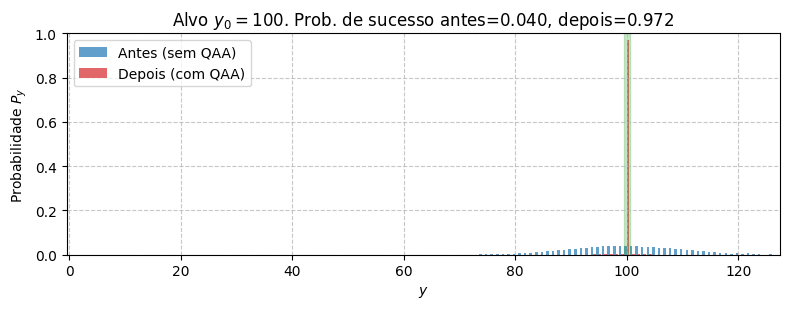

In [18]:
# P_y antes/depois
def plot_Py(y_vals, probs_no_amp, probs_amp, good_set, y0):
   
    wbar = 0.45
    
    fig, ax = plt.subplots(figsize=(8, 3.2))
    ax.bar(y_vals - wbar/2, probs_no_amp, color='tab:blue',
           width=wbar, alpha=0.7, label='Antes (sem QAA)')
    ax.bar(y_vals + wbar/2, probs_amp, color='tab:red',
           width=wbar, alpha=0.7, label='Depois (com QAA)')

    for y in good_set:
        ax.axvspan(y-0.5, y+0.5, alpha=0.25, color='tab:green')

    ax.set_xlabel(r'$y$')
    ax.set_ylabel(r'Probabilidade $P_y$')
    #ax.set_xticks(y_vals)
    ax.set_xlim(-0.5, y_vals[-1] + 0.5)
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_title(
        rf"Alvo $y_0={y0}$. Prob. de sucesso antes={probs_no_amp[good_set].sum():.3f}, "
        rf"depois={probs_amp[good_set].sum():.3f}"
    )
    plt.tight_layout()
    plt.show()


# Salvar dados
def salvar_Py_csv(filename, y_vals, probs_before, probs_after, good_set, meta=None):
    good_set = set(good_set)
    df = pd.DataFrame({
        "y": np.asarray(y_vals, dtype=int),
        "P_before": np.asarray(probs_before, dtype=float),
        "P_after":  np.asarray(probs_after, dtype=float),
        "is_good":  [1 if int(y) in good_set else 0 for y in y_vals],
    })
    # Metadados repetidos por linha (prático para filtrar depois)
    if meta is not None:
        for k, v in meta.items():
            df[k] = v
    df.to_csv(filename, index=False)
    return df


plot_Py(y_vals, probs_no_amp, probs, good_set, y0_eff_val)

meta = dict(
    num_qubits=num_qubits,
    N=N,
    N_max=N_max,
    kappa=kappa,
    t_int=float(t_f_int),
    w=w,
    y0=int(y0_eff_val),
)

df_out = salvar_Py_csv(
    f"Py_{num_qubits}q_{y0_eff_val}fock.csv",
    y_vals=y_vals,
    probs_before=probs_no_amp_last,
    probs_after=probs_amp_last,
    good_set=good_set,
    meta=meta
)

In [6]:
# =========================================================
# Funções
# =========================================================
def qft(m):
    if m < 1:
        raise ValueError("Minimum value of N can be 1")
    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)  # Lista de y: [0, 2^m-1]
    L, C = np.meshgrid(y, y)  # L - cópia de y nas linhas, C - cópia de y nas colunas
    P = phase * (L * C)  # Matriz de fase para cada combinação de estados
    P = np.exp(P)        # Matriz de transformação de fase exponencial
    dim = [[2] * m, [2] * m]  # Dimensão da matriz
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)

def construir_operadores(num_qubits, dim_q, dim_f):
    # Operadores σ_-
    sigma_m = []
    for q in range(num_qubits):
        op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
        op_list.append(qt.qeye(dim_f))
        op_list[q] = qt.sigmam()
        sigma_m.append(qt.tensor(op_list))
    # Operador a (aniquilação no modo do campo)
    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
    op_list.append(qt.qeye(dim_f))
    op_list[-1] = qt.destroy(dim_f)
    a = qt.tensor(op_list)
    # QFT total (qubits) ⊗ I_campo
    qft_total = qt.tensor(qft(num_qubits), qt.qeye(dim_f))
    return sigma_m, a, qft_total

def preparar_estado_inicial(num_qubits, dim_f, N):
    state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]
    alpha = np.sqrt(N) 
    state_i_field = qt.coherent(dim_f, alpha)
    state_i = qt.tensor(state_i_qubits + [state_i_field])
    return state_i_qubits, state_i_field, state_i

def construir_base_qubits(num_qubits):
    basis_states = []
    for bits in itertools.product([0, 1], repeat=num_qubits):
        state = qt.tensor([qt.basis(2, bit) for bit in bits])
        basis_states.append(state)
    return basis_states

def c_eff(t, args):
    return 1.0 if t <= args["t_f_int"] else 0.0

def construir_estado_puro_do_campo(state_total, num_qubits):
    rho_f = state_total.ptrace(num_qubits)
    vals, vecs = rho_f.eigenstates()
    state_f_puro = sum(np.sqrt(val) * vec for val, vec in zip(vals, vecs))
    return state_f_puro.unit()

def last_state_qobj(result, template_state=None):
    x = result.states
    while isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            raise ValueError("result.states está vazio.")
        x = x[-1]
    if isinstance(x, qt.Qobj):
        return x
    arr = np.asarray(x, dtype=complex).reshape((-1, 1))
    if template_state is not None:
        dims = template_state.dims
    else:
        dims = [[arr.shape[0]], [1]]
    return qt.Qobj(arr, dims=dims)

def y_from_N(N, num_qubits, N_max):
    """  
    Cria o índice-y alvo
    N % N_max: fase efetiva periódica em N_max
    N % N_max) * (2**num_qubits) / N_max: valor real que a QPE retorna da fração theta para o valor y
    round: arredonda para garantir y inteiro
    int e % (2**num_qubits): garante que o round não aproxime para fora do intervalo
    """
    return int(np.round((N % N_max) * (2**num_qubits) / N_max)) % (2**num_qubits)

def projector_y(y, num_qubits):
    """ 
    Cria o projetor de cada y 
    format: transforma o inteiro y em representação binária com num_qubits
    bits: associa cada bit string a um inteiro, incluído numa lista
    ket: base computacional correspondente aos bits
    """
    
    bits = list(map(int, format(y, f'0{num_qubits}b')))
    ket  = qt.tensor([qt.basis(2, b) for b in bits])
    return ket*ket.dag()

def bit_reverse(y, m):
    """
    Converte a ordem dos bits, segundo a convenção comum em QFT quando não se usam swaps finais
    Em vez de add SWAPs na função, aplicamos bit_reverse ao alvo teórico y0 para alinhar as convenções
    f'{y:0{m}b}': escreve y em binário com m bits
    [::-1]: inverte a string
    int(..., 2): lê a string invertida como inteiro base 2
    """
    return int(f'{y:0{m}b}'[::-1], 2)

def circ_dist(a, b, M):
    """
    Calcular distância circular (em anel) entre fases
    circ_dist(a,b,M)=min(∣a−b∣,M−∣a−b∣).
    """
    d = abs(a-b)
    return min(d, M-d)

def succ(r): 
    """
    Função sucesso para cada r candidato
    """
    return np.sin((2*r + 1)*theta)**2


# Mapa de Fock”: fidelidade vs $N$ (para um número fixo de qubits)

Ideia: mostrar até que valor de $N$ o protocolo ainda gera bons estados de Fock (por ex., fidelidade ≥ 0.9).

In [18]:
def roda_protocolo(num_qubits, N, kappa):
    # =========================
    # Parâmetros
    # =========================
    N_max = 2 ** num_qubits      # Grade para QPE (discretização)
    dim_q = 2                    # Dimensão dos qubits
    dim_f = N_max                # Dimensão do campo
   
    # Escala de tempo para uma rodada da QPE (irrelevante sem dissipação)
    T_vm = 5.0 / kappa
    num_qpe = 1                             # sempre 1              
    frac_int = 0.0002                       # 10^{-3}/kappa
    t_ciclo = T_vm / num_qpe
    t_f_int = frac_int * t_ciclo
    t_list_round = np.array([0.0, t_f_int]) # Como não há dissiparação, só dois pontos
    
    # Calibração: g_k * t_f_int = 2π * 2^k / N_max
    g_list = [(2*np.pi * (2**g) / N_max) / t_f_int for g in range(num_qubits)]
    g_list = g_list[::-1]



    # =========================================================
    # Operadores e estados
    # =========================================================
    sigma_m, a, qft_total = construir_operadores(num_qubits, dim_q, dim_f)
    n_op = a.dag() * a
    state_i_qubits, state_i_field, state_i = preparar_estado_inicial(num_qubits, dim_f, N)
    
    basis_states = construir_base_qubits(num_qubits)
    proj_list = [qt.tensor(s * s.dag(), qt.qeye(dim_f)) for s in basis_states]
    proj_list_qft = [qft_total * P * qft_total.dag() for P in proj_list]
    
    # Operador de colapso nulo
    c_ops = [np.sqrt(kappa) * a]
    
    H_eff = 0
    for q in range(num_qubits):
        H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
    H_free = 0 * H_eff
    H_td = [[H_eff, c_eff]]

    # =====
    # QAA 
    # =====
    # Semilargura da janela de y
    w  = 0  
    # Máximo de iterações
    r_cap = 30    
    
    # Operadores identidade campo e qubits
    I_f = qt.qeye(dim_f) 
    I_q = qt.tensor([qt.qeye(2) for _ in range(num_qubits)])
    I_total = qt.tensor(I_q, I_f)
    
    
    # =========================
    # Evolução via Monte Carlo 
    # =========================
    ntraj_global = 1
    prob_global_ntraj_list = np.zeros((num_qpe, 2**num_qubits), dtype=float)
    mean_photons = np.zeros(num_qpe, dtype=float)
    
    opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
                   store_states=False, store_final_state=True)
    
    # Semente aleatória
    qt.settings.mc_seed = np.random.randint(1e9)
    
    # Evolução (vira SE, pois não há dissipação)
    data = qt.mcsolve(H_td, state_i, t_list_round, c_ops, e_ops=None,
                        args={"t_f_int": t_f_int}, options=opts, ntraj=1, progress_bar=None)
    
    # Estado final
    state_f = last_state_qobj(data, template_state=state_i)
    
    # Probabilidade SEM amplificação
    probs_no_amp = np.real(qt.expect(proj_list_qft, state_f))
    probs_no_amp = np.clip(probs_no_amp, 0.0, 1.0)
    s0 = probs_no_amp.sum()
    if s0 > 0 and abs(s0 - 1.0) > 1e-12:
        probs_no_amp /= s0
    
    
    # Alvo da QPE
    y0_eff_val = y_from_N(N, num_qubits, N_max)   
    y_peak = int(np.argmax(probs_no_amp))    # só para verificação
            
    # Limita o conjunto alvo do oráculo
    good_set = list(range(max(0, y0_eff_val - w), min(N_max, y0_eff_val + w + 1)))
            
    # Definição do oráculo
    ## Projetores dentro do intervalo adotado
    P_good_comp = sum(projector_y(y, num_qubits) for y in good_set) 
    
    ## Phase oracle / oráculo de Grove / S_chi: reflexão em torno do subespaço good
    ### Fase -1 se y pertence ao conjunto good
    S_good_comp = (I_q - 2*P_good_comp)
    
    ## Transforma na base da IQFT
    S_chi_qft_qubits = qft(num_qubits) * S_good_comp * qft(num_qubits).dag()
    S_chi_total = qt.tensor(S_chi_qft_qubits, I_f)
        
    
    # Reflexão em torno do estado preparado 
    P_psi_total = state_f * state_f.dag()
    S_psi_total = (I_total - 2 * P_psi_total)
    
    # QAA nos qubits 
    state_after_y = state_f
            
    # Número de iterações de Grover (probabilidade inicial de sucesso na medida em y)
    a0 = float(np.clip(np.sum([probs_no_amp[y] for y in good_set]), 0.0, 1.0))
    if a0 <= 0.0:
        r_y = 2
    else:
        ## Número de iterações de Grover
        theta = np.arcsin(np.sqrt(a0))
        r_otimo = np.pi/(4.0*theta) - 0.5
                
        cand = [int(np.floor(r_otimo)), int(np.ceil(r_otimo))]         # maior (floor) ou menor (ceil) inteiro mais próximo
        cand = [int(np.clip(r, 0, r_cap)) for r in cand]               # clip para manter no intervalo permitido

        # ---> define succ AQUI, usando a theta local
        def succ(r):
            return np.sin((2*r + 1)*theta)**2
                
        r_y = max(cand, key=succ)                                      # Escolhe o r com maior probabilidade final
    
            
    ## Aplica amplificação (passo de Grover)
    G_y = S_psi_total * S_chi_total
    for _ in range(r_y):
        state_after_y = G_y * state_after_y
                    
    state_f_amp = state_after_y
    
    # Probabilidade COM amplificação (deslocamento das probabilidades em torno dos valores de good_set)
    probs = np.real(qt.expect(proj_list_qft, state_f_amp))
    probs = np.clip(probs, 0.0, 1.0)
    s = probs.sum()
    if s > 0 and abs(s - 1.0) > 1e-12:
        probs /= s
    prob_global_ntraj_list = probs
    
    # Número de fótons (não precisa usar o amplificado pq ele só atua nos qubits)
    mean_photons = float(np.real(qt.expect(n_op, state_f)))
    
    # Estado do campo condicionado ao sucesso (medição nos qubits)
    P_good_qft_total = sum(proj_list_qft[y] for y in good_set)
    p_succ = float(np.real((state_f_amp.dag() * P_good_qft_total * state_f_amp).tr()))
    
    if p_succ > 1e-14:
        state_cond = (P_good_qft_total * state_f_amp).unit()
        rho_field_cond = state_cond.ptrace(num_qubits)
        ket_N = qt.fock(dim_f, N)
        fid_N = float(np.real((ket_N.dag() * rho_field_cond * ket_N)[0,0]))    
    else:
        rho_field_cond = None
        fid_N = 0.0

    
    
    resultados = {
        "N": N,
        "num_qubits": num_qubits,
        "kappa": kappa,
        "a0": a0,
        "p_succ_y_before": float(np.sum([probs_no_amp[y] for y in good_set])),
        "p_succ_y_after": float(np.sum([probs[y] for y in good_set])),
        "fid_N": fid_N,
        "r_y": r_y
    }
    return resultados

In [3]:
# Varrer os estados de Fock N

num_qubits = 6
kappa = 1.0

Ns = np.arange(1, 30)   
fid_list = []
psucc_list = []
ry_list = []

for N in Ns:
    res = roda_protocolo(num_qubits=num_qubits, N=N, kappa=kappa)
    fid_list.append(res["fid_N"])
    psucc_list.append(res["p_succ_y_after"])
    ry_list.append(res["r_y"])

fid_list = np.array(fid_list)
psucc_list = np.array(psucc_list)
ry_list = np.array(ry_list)

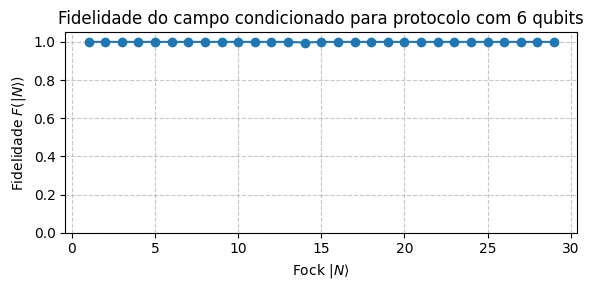

In [4]:
# Fidelidade vs N

plt.figure(figsize=(6,3))
plt.plot(Ns, fid_list, marker='o')
plt.xlabel(r'Fock $|N\rangle$')
plt.ylabel(r'Fidelidade $F(|N\rangle)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(fr'Fidelidade do campo condicionado para protocolo com {num_qubits} qubits')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


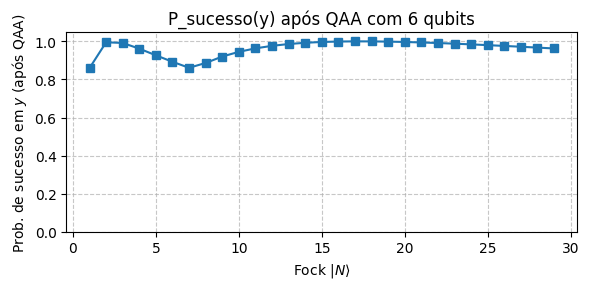

In [9]:
# Probabilidade de sucesso vs N

plt.figure(figsize=(6,3))
plt.plot(Ns, psucc_list, marker='s')
plt.xlabel(r'Fock $|N\rangle$')
plt.ylabel(r'Prob. de sucesso em $y$ (após QAA)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(fr'P_sucesso(y) após QAA com {num_qubits} qubits')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


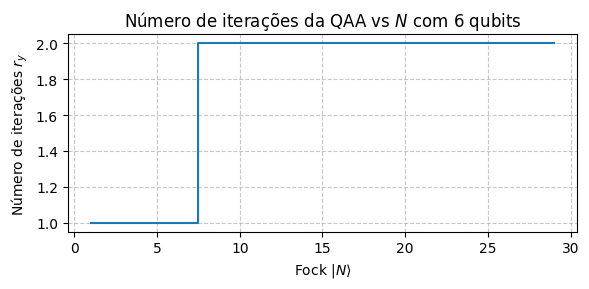

In [10]:
# Número de iterações de Grover vs N

plt.figure(figsize=(6,3))
plt.step(Ns, ry_list, where='mid')
plt.xlabel(r'Fock $|N\rangle$')
plt.ylabel(r'Número de iterações $r_y$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(fr'Número de iterações da QAA vs $N$ com {num_qubits} qubits')
plt.tight_layout()
plt.show()


# Benefício de aumentar num_qubits: melhora na fidelidade / P_sucesso.

In [6]:
# fidelidade vs número de qubits (para um N fixo)

num_qubits_list = [5, 6, 7]
N = 30
kappa = 1.0

fid_list = []
psucc_list = []

for nq in num_qubits_list:
    res = roda_protocolo(num_qubits=nq, N=N, kappa=kappa)
    fid_list.append(res["fid_N"])
    psucc_list.append(res["p_succ_y_after"])

fid_list = np.array(fid_list)
psucc_list = np.array(psucc_list)


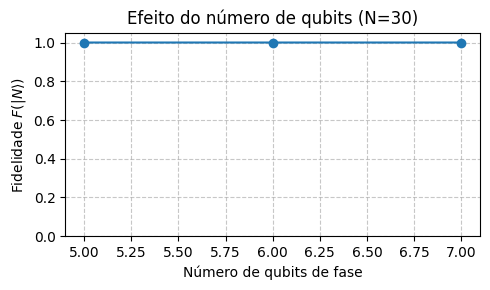

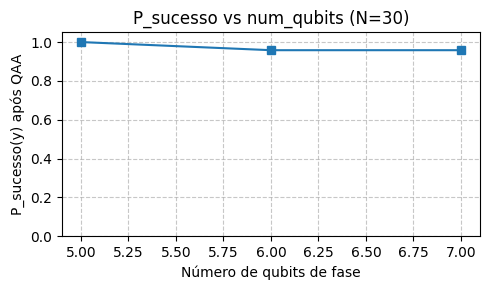

In [7]:
# Fidelidade vs num_qubits

plt.figure(figsize=(5,3))
plt.plot(num_qubits_list, fid_list, marker='o')
plt.xlabel('Número de qubits de fase')
plt.ylabel(r'Fidelidade $F(|N\rangle)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(fr'Efeito do número de qubits (N={N})')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Prob. de sucesso vs num_qubits

plt.figure(figsize=(5,3))
plt.plot(num_qubits_list, psucc_list, marker='s')
plt.xlabel('Número de qubits de fase')
plt.ylabel(r'P_sucesso(y) após QAA')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(fr'P_sucesso vs num_qubits (N={N})')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# Trade-off com decoerência ($\kappa$): zona “segura” de parâmetros.

Mapa de calor $P_\text{sucesso}$ em função de $N$ e num_qubits

In [10]:
Ns = np.arange(1, 5)
num_qubits_list = [3,4,5,6,7]
kappa = 1.0

P_succ_heat = np.zeros((len(num_qubits_list), len(Ns)))
Fid_heat = np.zeros_like(P_succ_heat)

for i, nq in enumerate(num_qubits_list):
    for j, N in enumerate(Ns):
        res = roda_protocolo(num_qubits=nq, N=N, kappa=kappa)
        P_succ_heat[i, j] = res["p_succ_y_after"]
        Fid_heat[i, j]    = res["fid_N"]


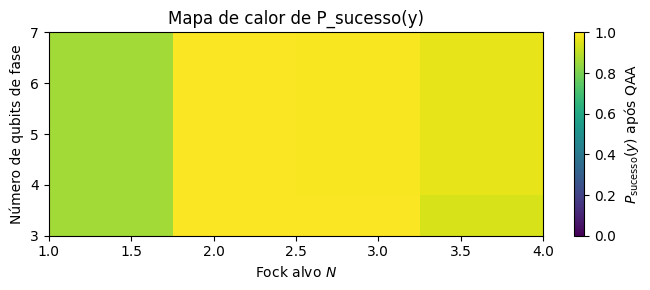

In [11]:
# Heatmap de Psucesso

plt.figure(figsize=(7,3))
im = plt.imshow(P_succ_heat, origin='lower', aspect='auto',
                extent=[Ns[0], Ns[-1], num_qubits_list[0], num_qubits_list[-1]],
                vmin=0, vmax=1)
plt.colorbar(im, label=r'$P_{\text{sucesso}}(y)$ após QAA')
plt.xlabel(r'Fock alvo $N$')
plt.ylabel('Número de qubits de fase')
plt.title('Mapa de calor de P_sucesso(y)')
plt.tight_layout()
plt.show()

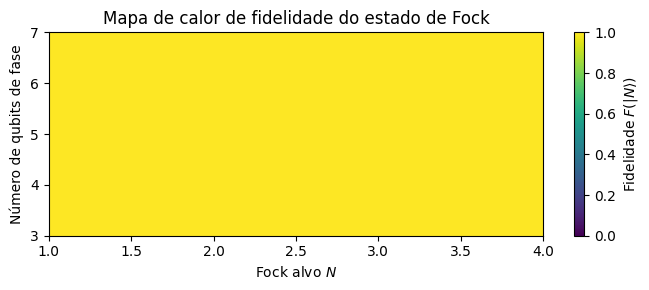

In [12]:
# Heatmap de fidelidade

plt.figure(figsize=(7,3))
im = plt.imshow(Fid_heat, origin='lower', aspect='auto',
                extent=[Ns[0], Ns[-1], num_qubits_list[0], num_qubits_list[-1]],
                vmin=0, vmax=1)
plt.colorbar(im, label=r'Fidelidade $F(|N\rangle)$')
plt.xlabel(r'Fock alvo $N$')
plt.ylabel('Número de qubits de fase')
plt.title('Mapa de calor de fidelidade do estado de Fock')
plt.tight_layout()
plt.show()

# Efeito da dissipação: fidelidade vs $\kappa$

In [3]:
def roda_protocolo(num_qubits, N, kappa, frac_int=2e-4, aplicar_qaa=True):
    """
    Roda uma única QPE + (opcionalmente) QAA para um dado Fock alvo N.
    - num_qubits : nº de qubits de fase
    - N          : Fock alvo
    - kappa      : taxa de decaimento do campo
    - frac_int   : fração do tempo total de ciclo usada na interação dispersiva
    - aplicar_qaa: se False, r_y = 0 (sem Grover/QAA)
    Retorna fidelidade condicionada, P_sucesso em y antes/depois da QAA, etc.
    """

    # =========================
    # Parâmetros
    # =========================
    N_max = 2 ** num_qubits      # grade da QPE
    dim_q = 2
    dim_f = N_max                # para manter coerência com sua simulação

    # Escala de tempo para uma rodada da QPE
    T_vm = 5.0 / kappa           # tempo "natural" do ciclo
    num_qpe = 1
    t_ciclo = T_vm / num_qpe
    t_f_int = frac_int * t_ciclo
    t_list_round = np.array([0.0, t_f_int])

    # Calibração: g_k * t_f_int = 2π * 2^k / N_max
    g_list = [(2*np.pi * (2**g) / N_max) / t_f_int for g in range(num_qubits)]
    g_list = g_list[::-1]

    # =========================================================
    # Operadores e estados
    # =========================================================
    sigma_m, a, qft_total = construir_operadores(num_qubits, dim_q, dim_f)
    n_op = a.dag() * a
    state_i_qubits, state_i_field, state_i = preparar_estado_inicial(num_qubits, dim_f, N)

    basis_states = construir_base_qubits(num_qubits)
    proj_list = [qt.tensor(s * s.dag(), qt.qeye(dim_f)) for s in basis_states]
    proj_list_qft = [qft_total * P * qft_total.dag() for P in proj_list]

    # dissipação do campo
    c_ops = [np.sqrt(kappa) * a]

    H_eff = 0
    for q in range(num_qubits):
        H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
    H_td = [[H_eff, c_eff]]

    # ===== QAA: parâmetros =====
    w  = 0          # só o y alvo
    r_cap = 30

    I_f = qt.qeye(dim_f)
    I_q = qt.tensor([qt.qeye(2) for _ in range(num_qubits)])
    I_total = qt.tensor(I_q, I_f)

    # =========================
    # Evolução
    # =========================
    opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
                   store_states=False, store_final_state=True)

    qt.settings.mc_seed = np.random.randint(1e9)

    data = qt.mcsolve(H_td, state_i, t_list_round, c_ops,
                      e_ops=None, args={"t_f_int": t_f_int},
                      options=opts, ntraj=1, progress_bar=None)

    state_f = last_state_qobj(data, template_state=state_i)

    # ===== Distribuição em y SEM QAA =====
    probs_no_amp = np.real(qt.expect(proj_list_qft, state_f))
    probs_no_amp = np.clip(probs_no_amp, 0.0, 1.0)
    s0 = probs_no_amp.sum()
    if s0 > 0 and abs(s0 - 1.0) > 1e-12:
        probs_no_amp /= s0

    # y alvo da QPE
    y0_eff_val = y_from_N(N, num_qubits, N_max)
    y_peak = int(np.argmax(probs_no_amp))  # só para diagnóstico

    good_set = list(range(max(0, y0_eff_val - w), min(N_max, y0_eff_val + w + 1)))

    # Projetor no conjunto "bom"
    P_good_comp = sum(projector_y(y, num_qubits) for y in good_set)

    # Oráculo em y (base computacional)
    S_good_comp = (I_q - 2*P_good_comp)

    # Oráculo na base QPE (antes da medida)
    S_chi_qft_qubits = qft(num_qubits) * S_good_comp * qft(num_qubits).dag()
    S_chi_total = qt.tensor(S_chi_qft_qubits, I_f)

    # Reflexão em torno de |ψ> (estado depois da QPE)
    P_psi_total = state_f * state_f.dag()
    S_psi_total = (I_total - 2 * P_psi_total)

    # ===== QAA nos qubits =====
    state_after_y = state_f

    # prob. inicial de sucesso (em y)
    a0 = float(np.clip(np.sum([probs_no_amp[y] for y in good_set]), 0.0, 1.0))

    if not aplicar_qaa:
        r_y = 0
    else:
        if a0 <= 0.0:
            r_y = 2
        else:
            theta = np.arcsin(np.sqrt(a0))
            r_otimo = np.pi/(4.0*theta) - 0.5

            cand = [int(np.floor(r_otimo)), int(np.ceil(r_otimo))]
            cand = [int(np.clip(r, 0, r_cap)) for r in cand]

            def succ(r):
                return np.sin((2*r + 1)*theta)**2

            r_y = max(cand, key=succ)

    # aplica r_y passos de Grover (pode ser 0)
    G_y = S_psi_total * S_chi_total
    for _ in range(r_y):
        state_after_y = G_y * state_after_y

    state_f_amp = state_after_y

    # ===== Probabilidades EM y DEPOIS da QAA =====
    probs_amp = np.real(qt.expect(proj_list_qft, state_f_amp))
    probs_amp = np.clip(probs_amp, 0.0, 1.0)
    s = probs_amp.sum()
    if s > 0 and abs(s - 1.0) > 1e-12:
        probs_amp /= s

    p_succ_before = float(np.sum([probs_no_amp[y] for y in good_set]))
    p_succ_after  = float(np.sum([probs_amp[y] for y in good_set]))

    # ===== Fidelidade do campo CONDICIONADA à medição "boa" =====
    P_good_qft_total = sum(proj_list_qft[y] for y in good_set)
    p_cond = float(np.real((state_f_amp.dag() * P_good_qft_total * state_f_amp).tr()))

    if p_cond > 1e-14:
        state_cond = (P_good_qft_total * state_f_amp).unit()
        rho_field_cond = state_cond.ptrace(num_qubits)
        ket_N = qt.fock(dim_f, N)
        fid_N = float(np.real((ket_N.dag() * rho_field_cond * ket_N)[0, 0]))
    else:
        fid_N = 0.0

    resultados = {
        "N": N,
        "num_qubits": num_qubits,
        "kappa": kappa,
        "frac_int": frac_int,
        "t_int": t_f_int,
        "a0": a0,
        "y_peak": y_peak,
        "y0_eff": y0_eff_val,
        "p_succ_y_before": p_succ_before,
        "p_succ_y_after": p_succ_after,
        "fid_cond": fid_N,
        "r_y": r_y,
    }
    return resultados


[2.00000000e-05 5.35593220e-05 8.71186441e-05 1.20677966e-04
 1.54237288e-04 1.87796610e-04 2.21355932e-04 2.54915254e-04
 2.88474576e-04 3.22033898e-04 3.55593220e-04 3.89152542e-04
 4.22711864e-04 4.56271186e-04 4.89830508e-04 5.23389831e-04
 5.56949153e-04 5.90508475e-04 6.24067797e-04 6.57627119e-04
 6.91186441e-04 7.24745763e-04 7.58305085e-04 7.91864407e-04
 8.25423729e-04 8.58983051e-04 8.92542373e-04 9.26101695e-04
 9.59661017e-04 9.93220339e-04 1.02677966e-03 1.06033898e-03
 1.09389831e-03 1.12745763e-03 1.16101695e-03 1.19457627e-03
 1.22813559e-03 1.26169492e-03 1.29525424e-03 1.32881356e-03
 1.36237288e-03 1.39593220e-03 1.42949153e-03 1.46305085e-03
 1.49661017e-03 1.53016949e-03 1.56372881e-03 1.59728814e-03
 1.63084746e-03 1.66440678e-03 1.69796610e-03 1.73152542e-03
 1.76508475e-03 1.79864407e-03 1.83220339e-03 1.86576271e-03
 1.89932203e-03 1.93288136e-03 1.96644068e-03 2.00000000e-03]


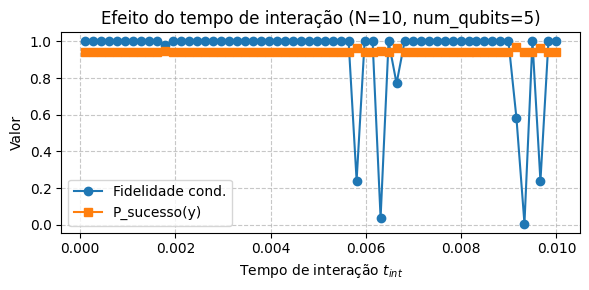

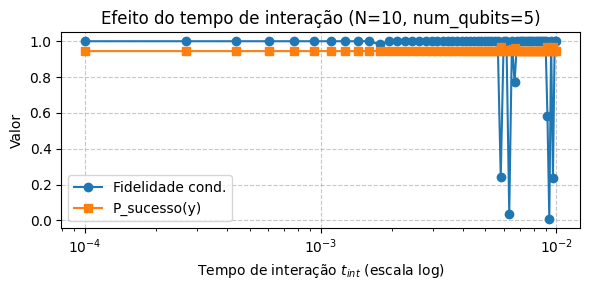

In [33]:
# --------- varredura do tempo de interação ---------
num_qubits = 5
N = 10
kappa = 1.0

frac_list = np.linspace(2e-5,2e-3,60)#np.logspace(-4, -2, 25)   # de 1e-4 a 1e-2
print(frac_list)
tint_list = []
fid_list  = []
psucc_list = []

for frac in frac_list:
    res = roda_protocolo(num_qubits=num_qubits, N=N, kappa=kappa,
                         frac_int=frac, aplicar_qaa=True)
    tint_list.append(res["t_int"])
    fid_list.append(res["fid_cond"])
    psucc_list.append(res["p_succ_y_after"])

tint_list = np.array(tint_list)
fid_list = np.array(fid_list)
psucc_list = np.array(psucc_list)

plt.figure(figsize=(6,3))
plt.plot(tint_list, fid_list, 'o-', label='Fidelidade cond.')
plt.plot(tint_list, psucc_list, 's-', label='P_sucesso(y)')
plt.xlabel('Tempo de interação $t_{int}$')
plt.ylabel('Valor')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.title(f'Efeito do tempo de interação (N={N}, num_qubits={num_qubits})')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.semilogx(tint_list, fid_list, 'o-', label='Fidelidade cond.')
plt.semilogx(tint_list, psucc_list, 's-', label='P_sucesso(y)')
plt.xlabel('Tempo de interação $t_{int}$ (escala log)')
plt.ylabel('Valor')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.title(f'Efeito do tempo de interação (N={N}, num_qubits={num_qubits})')
plt.tight_layout()
plt.show()


# Comparação direta “com vs sem QAA” em um único gráfico

In [21]:
# --------- comparação com vs sem QAA ---------
num_qubits = 5
kappa = 1.0
frac_int = 2e-4

Ns = np.arange(0, 20+1)

fid_sem = []
fid_com = []
psucc_sem = []
psucc_com = []
ry_list = []

for N in Ns:
    # sem QAA: aplicar_qaa=False (r_y = 0)
    res_sem = roda_protocolo(num_qubits=num_qubits, N=N,
                             kappa=kappa, frac_int=frac_int,
                             aplicar_qaa=False)
    fid_sem.append(res_sem["fid_cond"])
    psucc_sem.append(res_sem["p_succ_y_before"])  # sem Grover, before = after

    # com QAA
    res_com = roda_protocolo(num_qubits=num_qubits, N=N,
                             kappa=kappa, frac_int=frac_int,
                             aplicar_qaa=True)
    fid_com.append(res_com["fid_cond"])
    psucc_com.append(res_com["p_succ_y_after"])
    ry_list.append(res_com["r_y"])

fid_sem = np.array(fid_sem)
fid_com = np.array(fid_com)
psucc_sem = np.array(psucc_sem)
psucc_com = np.array(psucc_com)
ry_list = np.array(ry_list)


# Salvar dados
df = pd.DataFrame({
    "N": Ns.astype(int),
    "P_succ_semQAA": psucc_sem.astype(float),
    "P_succ_comQAA": psucc_com.astype(float),
    "r_y": ry_list.astype(int),
    "num_qubits": int(num_qubits),
    "kappa": float(kappa),
    "frac_int": float(frac_int),
})

csv_name = f"qpe_qaa_Ps_ry_{num_qubits}q.csv"
df.to_csv(csv_name, index=False)
print("Salvo:", csv_name)

Salvo: qpe_qaa_Ps_ry_5q.csv


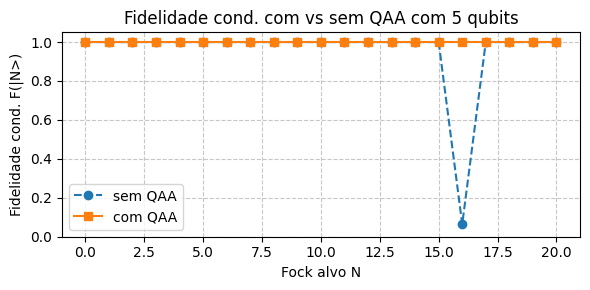

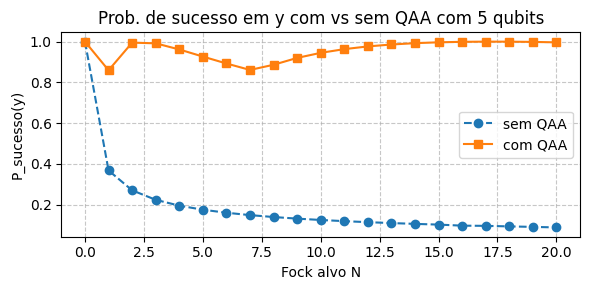

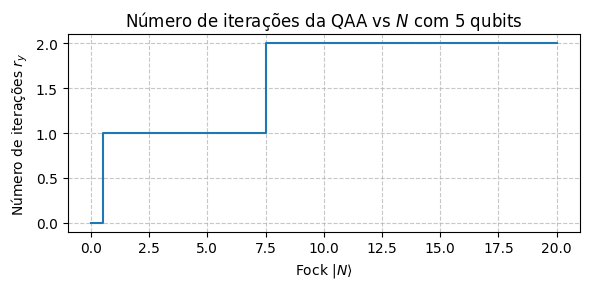

In [22]:
# --- Plots ---
plt.figure(figsize=(6,3))
plt.plot(Ns, fid_sem, 'o--', label='sem QAA')
plt.plot(Ns, fid_com, 's-',  label='com QAA')
plt.xlabel('Fock alvo N')
plt.ylabel('Fidelidade cond. F(|N>)')
plt.ylim(0,1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.title(f'Fidelidade cond. com vs sem QAA com {num_qubits} qubits')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(Ns, psucc_sem, 'o--', label='sem QAA')
plt.plot(Ns, psucc_com, 's-',  label='com QAA')
plt.xlabel('Fock alvo N')
plt.ylabel('P_sucesso(y)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.title(f'Prob. de sucesso em y com vs sem QAA com {num_qubits} qubits')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.step(Ns, ry_list, where='mid')
plt.xlabel(r'Fock $|N\rangle$')
plt.ylabel(r'Número de iterações $r_y$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(fr'Número de iterações da QAA vs $N$ com {num_qubits} qubits')
plt.tight_layout()
plt.show()


Fixando um $\alpha_0$ e gerando vários $\ket{N}$

In [14]:
# =========================================================
# Funções
# =========================================================
def qft(m):
    if m < 1:
        raise ValueError("Minimum value of N can be 1")
    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)  # Lista de y: [0, 2^m-1]
    L, C = np.meshgrid(y, y)  # L - cópia de y nas linhas, C - cópia de y nas colunas
    P = phase * (L * C)  # Matriz de fase para cada combinação de estados
    P = np.exp(P)        # Matriz de transformação de fase exponencial
    dim = [[2] * m, [2] * m]  # Dimensão da matriz
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)

def construir_operadores(num_qubits, dim_q, dim_f):
    # Operadores σ_-
    sigma_m = []
    for q in range(num_qubits):
        op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
        op_list.append(qt.qeye(dim_f))
        op_list[q] = qt.sigmam()
        sigma_m.append(qt.tensor(op_list))
    # Operador a (aniquilação no modo do campo)
    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
    op_list.append(qt.qeye(dim_f))
    op_list[-1] = qt.destroy(dim_f)
    a = qt.tensor(op_list)
    # QFT total (qubits) ⊗ I_campo
    qft_total = qt.tensor(qft(num_qubits), qt.qeye(dim_f))
    return sigma_m, a, qft_total

def preparar_estado_inicial(num_qubits, dim_f, alpha0):
    state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]
    state_i_field  = qt.coherent(dim_f, alpha0)   # <-- agora independe de N
    state_i = qt.tensor(state_i_qubits + [state_i_field])
    return state_i_qubits, state_i_field, state_i

def construir_base_qubits(num_qubits):
    basis_states = []
    for bits in itertools.product([0, 1], repeat=num_qubits):
        state = qt.tensor([qt.basis(2, bit) for bit in bits])
        basis_states.append(state)
    return basis_states

def c_eff(t, args):
    return 1.0 if t <= args["t_f_int"] else 0.0

def construir_estado_puro_do_campo(state_total, num_qubits):
    rho_f = state_total.ptrace(num_qubits)
    vals, vecs = rho_f.eigenstates()
    state_f_puro = sum(np.sqrt(val) * vec for val, vec in zip(vals, vecs))
    return state_f_puro.unit()

def last_state_qobj(result, template_state=None):
    x = result.states
    while isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            raise ValueError("result.states está vazio.")
        x = x[-1]
    if isinstance(x, qt.Qobj):
        return x
    arr = np.asarray(x, dtype=complex).reshape((-1, 1))
    if template_state is not None:
        dims = template_state.dims
    else:
        dims = [[arr.shape[0]], [1]]
    return qt.Qobj(arr, dims=dims)

def y_from_N(N, num_qubits, N_max):
    """  
    Cria o índice-y alvo
    N % N_max: fase efetiva periódica em N_max
    N % N_max) * (2**num_qubits) / N_max: valor real que a QPE retorna da fração theta para o valor y
    round: arredonda para garantir y inteiro
    int e % (2**num_qubits): garante que o round não aproxime para fora do intervalo
    """
    return int(np.round((N % N_max) * (2**num_qubits) / N_max)) % (2**num_qubits)

def projector_y(y, num_qubits):
    """ 
    Cria o projetor de cada y 
    format: transforma o inteiro y em representação binária com num_qubits
    bits: associa cada bit string a um inteiro, incluído numa lista
    ket: base computacional correspondente aos bits
    """
    
    bits = list(map(int, format(y, f'0{num_qubits}b')))
    ket  = qt.tensor([qt.basis(2, b) for b in bits])
    return ket*ket.dag()

def bit_reverse(y, m):
    """
    Converte a ordem dos bits, segundo a convenção comum em QFT quando não se usam swaps finais
    Em vez de add SWAPs na função, aplicamos bit_reverse ao alvo teórico y0 para alinhar as convenções
    f'{y:0{m}b}': escreve y em binário com m bits
    [::-1]: inverte a string
    int(..., 2): lê a string invertida como inteiro base 2
    """
    return int(f'{y:0{m}b}'[::-1], 2)

def circ_dist(a, b, M):
    """
    Calcular distância circular (em anel) entre fases
    circ_dist(a,b,M)=min(∣a−b∣,M−∣a−b∣).
    """
    d = abs(a-b)
    return min(d, M-d)

def succ(r): 
    """
    Função sucesso para cada r candidato
    """
    return np.sin((2*r + 1)*theta)**2

def roda_protocolo(num_qubits, N, kappa, frac_int=2e-4, aplicar_qaa=True, alpha0=1.0):
    """
    Roda uma única QPE + (opcionalmente) QAA para um dado Fock alvo N.
    - num_qubits : nº de qubits de fase
    - N          : Fock alvo
    - kappa      : taxa de decaimento do campo
    - frac_int   : fração do tempo total de ciclo usada na interação dispersiva
    - aplicar_qaa: se False, r_y = 0 (sem Grover/QAA)
    Retorna fidelidade condicionada, P_sucesso em y antes/depois da QAA, etc.
    """

    # =========================
    # Parâmetros
    # =========================
    N_max = 2 ** num_qubits      # grade da QPE
    dim_q = 2
    dim_f = N_max                # para manter coerência com sua simulação

    # Escala de tempo para uma rodada da QPE
    T_vm = 5.0 / kappa           # tempo "natural" do ciclo
    num_qpe = 1
    t_ciclo = T_vm / num_qpe
    t_f_int = frac_int * t_ciclo
    t_list_round = np.array([0.0, t_f_int])

    # Calibração: g_k * t_f_int = 2π * 2^k / N_max
    g_list = [(2*np.pi * (2**g) / N_max) / t_f_int for g in range(num_qubits)]
    g_list = g_list[::-1]

    # =========================================================
    # Operadores e estados
    # =========================================================
    sigma_m, a, qft_total = construir_operadores(num_qubits, dim_q, dim_f)
    n_op = a.dag() * a
    state_i_qubits, state_i_field, state_i = preparar_estado_inicial(num_qubits, dim_f, alpha0)

    basis_states = construir_base_qubits(num_qubits)
    proj_list = [qt.tensor(s * s.dag(), qt.qeye(dim_f)) for s in basis_states]
    proj_list_qft = [qft_total * P * qft_total.dag() for P in proj_list]

    # dissipação do campo
    c_ops = [np.sqrt(kappa) * a]

    H_eff = 0
    for q in range(num_qubits):
        H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
    H_td = [[H_eff, c_eff]]

    # ===== QAA: parâmetros =====
    w  = 0          # só o y alvo
    r_cap = 30

    I_f = qt.qeye(dim_f)
    I_q = qt.tensor([qt.qeye(2) for _ in range(num_qubits)])
    I_total = qt.tensor(I_q, I_f)

    # =========================
    # Evolução
    # =========================
    opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
                   store_states=False, store_final_state=True)

    qt.settings.mc_seed = np.random.randint(1e9)

    data = qt.mcsolve(H_td, state_i, t_list_round, c_ops,
                      e_ops=None, args={"t_f_int": t_f_int},
                      options=opts, ntraj=1, progress_bar=None)

    state_f = last_state_qobj(data, template_state=state_i)

    # ===== Distribuição em y SEM QAA =====
    probs_no_amp = np.real(qt.expect(proj_list_qft, state_f))
    probs_no_amp = np.clip(probs_no_amp, 0.0, 1.0)
    s0 = probs_no_amp.sum()
    if s0 > 0 and abs(s0 - 1.0) > 1e-12:
        probs_no_amp /= s0

    # y alvo da QPE
    y0_eff_val = y_from_N(N, num_qubits, N_max)
    y_peak = int(np.argmax(probs_no_amp))  # só para diagnóstico

    good_set = list(range(max(0, y0_eff_val - w), min(N_max, y0_eff_val + w + 1)))

    # Projetor no conjunto "bom"
    P_good_comp = sum(projector_y(y, num_qubits) for y in good_set)

    # Oráculo em y (base computacional)
    S_good_comp = (I_q - 2*P_good_comp)

    # Oráculo na base QPE (antes da medida)
    S_chi_qft_qubits = qft(num_qubits) * S_good_comp * qft(num_qubits).dag()
    S_chi_total = qt.tensor(S_chi_qft_qubits, I_f)

    # Reflexão em torno de |ψ> (estado depois da QPE)
    P_psi_total = state_f * state_f.dag()
    S_psi_total = (I_total - 2 * P_psi_total)

    # ===== QAA nos qubits =====
    state_after_y = state_f

    # prob. inicial de sucesso (em y)
    a0 = float(np.clip(np.sum([probs_no_amp[y] for y in good_set]), 0.0, 1.0))

    if not aplicar_qaa:
        r_y = 0
    else:
        if a0 <= 0.0:
            r_y = 2
        else:
            theta = np.arcsin(np.sqrt(a0))
            r_otimo = np.pi/(4.0*theta) - 0.5

            cand = [int(np.floor(r_otimo)), int(np.ceil(r_otimo))]
            cand = [int(np.clip(r, 0, r_cap)) for r in cand]

            def succ(r):
                return np.sin((2*r + 1)*theta)**2

            r_y = max(cand, key=succ)

    # aplica r_y passos de Grover (pode ser 0)
    G_y = S_psi_total * S_chi_total
    for _ in range(r_y):
        state_after_y = G_y * state_after_y

    state_f_amp = state_after_y

    # ===== Probabilidades EM y DEPOIS da QAA =====
    probs_amp = np.real(qt.expect(proj_list_qft, state_f_amp))
    probs_amp = np.clip(probs_amp, 0.0, 1.0)
    s = probs_amp.sum()
    if s > 0 and abs(s - 1.0) > 1e-12:
        probs_amp /= s

    p_succ_before = float(np.sum([probs_no_amp[y] for y in good_set]))
    p_succ_after  = float(np.sum([probs_amp[y] for y in good_set]))

    # ===== Fidelidade do campo CONDICIONADA à medição "boa" =====
    P_good_qft_total = sum(proj_list_qft[y] for y in good_set)
    p_cond = float(np.real((state_f_amp.dag() * P_good_qft_total * state_f_amp).tr()))

    if p_cond > 1e-14:
        state_cond = (P_good_qft_total * state_f_amp).unit()
        rho_field_cond = state_cond.ptrace(num_qubits)
        ket_N = qt.fock(dim_f, N)
        fid_N = float(np.real((ket_N.dag() * rho_field_cond * ket_N)[0, 0]))
    else:
        fid_N = 0.0

    resultados = {
        "N": N,
        "num_qubits": num_qubits,
        "kappa": kappa,
        "frac_int": frac_int,
        "t_int": t_f_int,
        "a0": a0,
        "y_peak": y_peak,
        "y0_eff": y0_eff_val,
        "p_succ_y_before": p_succ_before,
        "p_succ_y_after": p_succ_after,
        "fid_cond": fid_N,
        "r_y": r_y,
    }
    return resultados

# --------- comparação com vs sem QAA ---------
num_qubits = 5
kappa = 1.0
frac_int = 2e-4

# estado coerente inicial
N0 = 30
alpha0 = np.sqrt(N0)

Ns = np.arange(0, 20+1)

fid_sem = []
fid_com = []
psucc_sem = []
psucc_com = []
ry_list = []

for N in Ns:
    # sem QAA: aplicar_qaa=False (r_y = 0)
    res_sem = roda_protocolo(num_qubits=num_qubits, N=N,
                             kappa=kappa, frac_int=frac_int,
                             aplicar_qaa=False)
    fid_sem.append(res_sem["fid_cond"])
    psucc_sem.append(res_sem["p_succ_y_before"])  # sem Grover, before = after

    # com QAA
    res_com = roda_protocolo(num_qubits=num_qubits, N=N,
                             kappa=kappa, frac_int=frac_int,
                             aplicar_qaa=True)
    fid_com.append(res_com["fid_cond"])
    psucc_com.append(res_com["p_succ_y_after"])
    ry_list.append(res_com["r_y"])

fid_sem = np.array(fid_sem)
fid_com = np.array(fid_com)
psucc_sem = np.array(psucc_sem)
psucc_com = np.array(psucc_com)
ry_list = np.array(ry_list)


# Salvar dados
df = pd.DataFrame({
    "N": Ns.astype(int),
    "P_succ_semQAA": psucc_sem.astype(float),
    "P_succ_comQAA": psucc_com.astype(float),
    "r_y": ry_list.astype(int),
    "num_qubits": int(num_qubits),
    "kappa": float(kappa),
    "frac_int": float(frac_int),
    "alpha0": float(alpha0),
    "N0": float(N0),
})

csv_name = f"qpe_qaa_Ps_ry_{num_qubits}q.csv"
df.to_csv(csv_name, index=False)
print("Salvo:", csv_name)

Salvo: qpe_qaa_Ps_ry_5q.csv


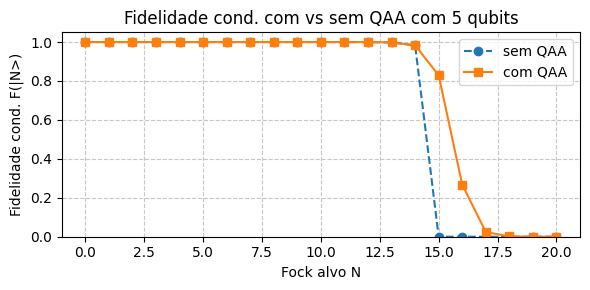

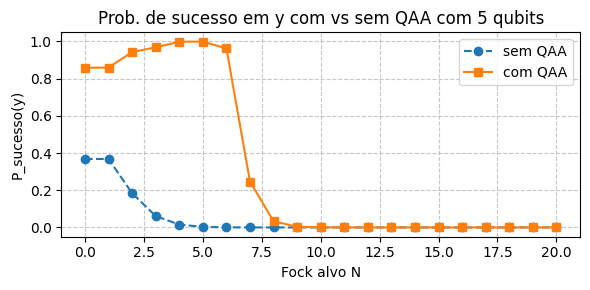

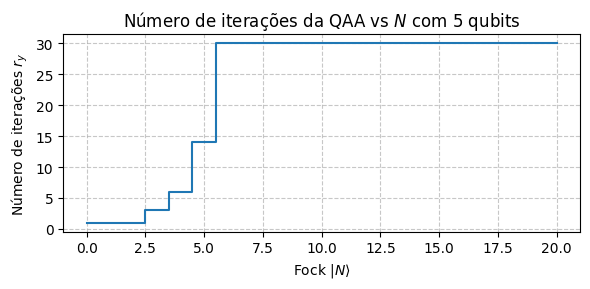

In [15]:
# --- Plots ---
plt.figure(figsize=(6,3))
plt.plot(Ns, fid_sem, 'o--', label='sem QAA')
plt.plot(Ns, fid_com, 's-',  label='com QAA')
plt.xlabel('Fock alvo N')
plt.ylabel('Fidelidade cond. F(|N>)')
plt.ylim(0,1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.title(f'Fidelidade cond. com vs sem QAA com {num_qubits} qubits')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(Ns, psucc_sem, 'o--', label='sem QAA')
plt.plot(Ns, psucc_com, 's-',  label='com QAA')
plt.xlabel('Fock alvo N')
plt.ylabel('P_sucesso(y)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.title(f'Prob. de sucesso em y com vs sem QAA com {num_qubits} qubits')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.step(Ns, ry_list, where='mid')
plt.xlabel(r'Fock $|N\rangle$')
plt.ylabel(r'Número de iterações $r_y$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(fr'Número de iterações da QAA vs $N$ com {num_qubits} qubits')
plt.tight_layout()
plt.show()

# “Mapa de estados de Fock geráveis” (scatter/heatmap)

In [4]:
# parâmetros globais
kappa    = 1.0
frac_int = 2e-4         # use o que vc vem usando nas simulações
num_qubits_list = [1, 2, 3, 4, 5, 6, 7, 8]   # pode estender depois

# critérios de “estado bem gerado”
F_min = 0.0      # fidelidade mínima
P_min = 0.0      # prob. de sucesso mínima

# listas para os pontos bons
good_N  = []
good_nq = []
good_P  = []   # opcional: guardar P_sucesso pra colorir

for nq in num_qubits_list:
    N_max = 2**nq   # sua simulação usa dim_f = N_max
    # varre N, mas evita N=0 se não quiser (mantenho N>=1)
    for N in range(0, N_max): 
        res = roda_protocolo(num_qubits=nq, N=N,
                             kappa=kappa, frac_int=frac_int,
                             aplicar_qaa=True)
        F_cond = res["fid_cond"]
        P_succ = res["p_succ_y_after"]

        if P_succ >= P_min:
            good_N.append(N)
            good_nq.append(nq)
            good_P.append(P_succ)

good_N  = np.array(good_N)
good_nq = np.array(good_nq)
good_P  = np.array(good_P)

# Salvar dados
df_out = pd.DataFrame({
    "N": good_N.astype(int),
    "num_qubits": good_nq.astype(int),
    "p_succ_y_after": good_P.astype(float),
})


csv_out = "qpe_qaa_fock_map_points.csv"
df_out.to_csv(csv_out, index=False)
print(f"Salvo: {csv_out}  ({len(df_out)} pontos)")

MemoryError: Unable to allocate 1.93 GiB for an array with shape (129539726,) and data type complex128

In [ ]:
plt.figure(figsize=(6,4))
sc = plt.scatter(good_N, good_nq, c=good_P,
                 cmap='viridis', vmin=P_min, vmax=1.0,
                 edgecolor='k', s=60)
plt.colorbar(sc, label=r'$P_{\rm sucesso}(y)$')
plt.xlabel(r'Estado de Fock alvo $|N\rangle$')
plt.ylabel('Número de qubits de fase')
plt.ylim(num_qubits_list[0]-0.25, num_qubits_list[-1]+0.25)
plt.title('Estados de Fock gerados')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Versão paralelizada e mais leve por não definir explicitamente os projetores

In [7]:
import os
# IMPORTANTÍSSIMO p/ estabilidade (principalmente com numpy+BLAS em paralelo)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import numpy as np
import qutip as qt
from qutip.solver import Options

# -------------------------
# cache global (por processo)
# -------------------------
_PRECOMP = {}

def _get_precomp(num_qubits, kappa, frac_int):
    """
    Cria e guarda objetos caros 1x por (num_qubits, kappa, frac_int).
    Cache é por-processo (bom p/ multiprocessing).
    """
    key = (int(num_qubits), float(kappa), float(frac_int))
    if key in _PRECOMP:
        return _PRECOMP[key]

    nq = int(num_qubits)
    N_max = 2 ** nq
    dim_qb = 2 ** nq
    dim_f  = N_max

    # tempo
    T_vm = 5.0 / kappa
    t_f_int = frac_int * T_vm
    t_list_round = np.array([0.0, t_f_int])

    # calibração
    g_list = [(2*np.pi * (2**g) / N_max) / t_f_int for g in range(nq)][::-1]

    # operadores (caros) - usa suas funções
    sigma_m, a, _ = construir_operadores(nq, 2, dim_f)

    # Hamiltoniano efetivo
    H_eff = 0
    for q in range(nq):
        H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
    H_td = [[H_eff, c_eff]]

    # dissipação
    c_ops = [np.sqrt(kappa) * a]

    # |+>^n qubits (fixo)
    plus = (qt.basis(2,0) + qt.basis(2,1)).unit()
    state_qubits = qt.tensor([plus]*nq)

    # QFT/IQFT pequenos (numpy)
    QFT  = qft(nq).full()
    IQFT = qft(nq).dag().full()

    # solver options (fixo)
    opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
                   store_states=False, store_final_state=True)

    out = dict(
        nq=nq, N_max=N_max, dim_qb=dim_qb, dim_f=dim_f,
        t_int=t_f_int, t_list_round=t_list_round,
        H_td=H_td, c_ops=c_ops, opts=opts,
        state_qubits=state_qubits,
        QFT=QFT, IQFT=IQFT
    )
    _PRECOMP[key] = out
    return out


def _apply_qubit_op(op_q, vec, dim_qb, dim_f):
    V = vec.reshape((dim_qb, dim_f), order="C")
    V2 = op_q @ V
    return V2.reshape((dim_qb*dim_f, 1), order="C")

def _probs_y(vec, IQFT, dim_qb, dim_f):
    V = vec.reshape((dim_qb, dim_f), order="C")
    Vc = IQFT @ V
    P = np.sum(np.abs(Vc)**2, axis=1).real
    P = np.clip(P, 0.0, 1.0)
    s = P.sum()
    if s > 0:
        P /= s
    return P, Vc


def roda_protocolo_cached(num_qubits, N, kappa, frac_int=2e-4, aplicar_qaa=True, seed=None):
    P = _get_precomp(num_qubits, kappa, frac_int)

    nq     = P["nq"]
    N_max  = P["N_max"]
    dim_qb = P["dim_qb"]
    dim_f  = P["dim_f"]

    # estado inicial: qubits fixos |+>^n + campo coerente com alpha=sqrt(N) (seu padrão atual)
    alpha = np.sqrt(N)
    state_field = qt.coherent(dim_f, alpha)
    state_i = qt.tensor(P["state_qubits"], state_field)

    # seed por traj
    if seed is None:
        qt.settings.mc_seed = np.random.randint(1_000_000_000)
    else:
        qt.settings.mc_seed = int(seed) % 1_000_000_000

    data = qt.mcsolve(P["H_td"], state_i, P["t_list_round"], P["c_ops"],
                      e_ops=None, args={"t_f_int": P["t_int"]},
                      options=P["opts"], ntraj=1, progress_bar=None)

    state_f = last_state_qobj(data, template_state=state_i)
    psi = state_f.full()
    nrm = np.linalg.norm(psi)
    if nrm > 0:
        psi = psi / nrm

    # alvo da QPE
    y0 = y_from_N(N, nq, N_max)
    good_set = [y0]  # w=0

    # P_y antes
    probs_before, Vc0 = _probs_y(psi, P["IQFT"], dim_qb, dim_f)
    p_succ_before = float(probs_before[good_set].sum())
    a0 = float(np.clip(p_succ_before, 0.0, 1.0))

    # construir oracle no espaço QFT sem qutip (diag ±1)
    s = np.ones(dim_qb, dtype=complex)
    for yy in good_set:
        s[yy] = -1.0
    # S_chi_qft = QFT @ diag(s) @ QFT†
    S_chi_qft = P["QFT"] @ (s[:, None] * P["QFT"].conj().T)

    # escolher r_y
    if not aplicar_qaa:
        r_y = 0
    else:
        r_cap = 30
        if a0 <= 0.0:
            r_y = 2
        else:
            theta = np.arcsin(np.sqrt(a0))
            r_opt = np.pi/(4.0*theta) - 0.5
            cand = [int(np.floor(r_opt)), int(np.ceil(r_opt))]
            cand = [int(np.clip(r, 0, r_cap)) for r in cand]
            def succ(r): return np.sin((2*r + 1)*theta)**2
            r_y = max(cand, key=succ)

    # Grover sem construir S_psi (aplica reflexão em vetor)
    phi = psi.copy()
    for _ in range(r_y):
        phi = _apply_qubit_op(S_chi_qft, phi, dim_qb, dim_f)       # oracle
        overlap = (psi.conj().T @ phi)[0, 0]
        phi = phi - 2.0 * psi * overlap                            # reflexão em torno de |psi>

    probs_after, Vc = _probs_y(phi, P["IQFT"], dim_qb, dim_f)
    p_succ_after = float(probs_after[good_set].sum())

    # fidelidade condicionada sem ptrace
    if (p_succ_after > 1e-14) and (0 <= N < dim_f):
        fid = float(np.sum(np.abs(Vc[good_set, N])**2) / p_succ_after)
    else:
        fid = 0.0

    return dict(
        N=int(N), num_qubits=int(nq), kappa=float(kappa), frac_int=float(frac_int),
        t_int=float(P["t_int"]),
        a0=float(a0),
        y0_eff=int(y0),
        y_peak=int(np.argmax(probs_before)),
        p_succ_y_before=float(p_succ_before),
        p_succ_y_after=float(p_succ_after),
        fid_cond=float(fid),
        r_y=int(r_y),
    )


In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import numpy as np

def run_map_serial(num_qubits_list, kappa=1.0, frac_int=2e-4, out_csv="qpe_qaa_fock_map_points.csv",
                   aplicar_qaa=True, checkpoint_every=10, seed0=12345):
    rows = []
    it = 0
    for nq in num_qubits_list:
        for N in range(0, 2**nq):
            it += 1
            seed = seed0 + 1000*nq + N
            res = roda_protocolo_cached(nq, N, kappa, frac_int, aplicar_qaa, seed=seed)
            rows.append(res)

            if (it % checkpoint_every) == 0:
                pd.DataFrame(rows).to_csv(out_csv, index=False)
                print(f"checkpoint: {it} pontos salvos em {out_csv}")

    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print("final:", out_csv, "linhas:", len(df))
    return df

# exemplo:
df = run_map_serial([1,2,3,4,5,6,7], checkpoint_every=5)


checkpoint: 5 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 10 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 15 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 20 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 25 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 30 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 35 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 40 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 45 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 50 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 55 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 60 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 65 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 70 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 75 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 80 pontos salvos em qpe_qaa_fock_map_points.csv
checkpoint: 85 pontos salvos em qpe_qaa_f

# N máximo “bom” vs número de qubits

In [ ]:
kappa    = 1.0
frac_int = 2e-4
num_qubits_list = [3, 4, 5, 6, 7]

F_min = 0.99
P_min = 0.90

Nmax_good_list = []

for nq in num_qubits_list:
    N_max = 2**nq
    N_good_max = 0  # se nada passar no critério, fica 0

    for N in range(1, N_max):
        res = roda_protocolo(num_qubits=nq, N=N,
                             kappa=kappa, frac_int=frac_int,
                             aplicar_qaa=True)
        F_cond = res["fid_cond"]
        P_succ = res["p_succ_y_after"]

        if (F_cond >= F_min) and (P_succ >= P_min):
            N_good_max = N  # sempre guarda o maior que satisfaz

    Nmax_good_list.append(N_good_max)

Nmax_good_list = np.array(Nmax_good_list)

plt.figure(figsize=(5,3))
plt.plot(num_qubits_list, Nmax_good_list, 'o-')
plt.xlabel('Número de qubits de fase')
plt.ylabel(r'Maior Fock $N$ bem gerado')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(r'Escalabilidade: $N_{\max}^{\rm bom}$ vs número de qubits')
plt.tight_layout()
plt.show()
